In [1]:
from __future__ import print_function


from epinet_fun.func_generate_traindata import generate_traindata_for_train
from epinet_fun.func_generate_traindata import data_augmentation_for_train
from epinet_fun.func_generate_traindata import generate_traindata512
from epinet_fun.func_makeinput import make_multiinput
from epinet_fun.func_pfm import read_pfm
from epinet_fun.func_savedata import display_current_output
from epinet_fun.util import load_LFdata

from network.model_for_eval_simple import *
import numpy as np
import matplotlib.pyplot as plt

import h5py
import os
import time
import datetime
import threading
import configparser
import json
from PIL import Image, ImageEnhance, ImageOps
#from epinet_fun.func_middle_output import middle_layer_output
import imageio

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils import data

import matplotlib.pyplot as plt
import time
from PIL import Image

In [2]:
inifile = configparser.ConfigParser()
inifile.read('./config.ini', 'UTF-8')

train_dataset_list = json.loads(inifile.get('dataset_list','train_dataset_list'))
test_dataset_list = json.loads(inifile.get('dataset_list','test_dataset_list'))

dataset_path = inifile.get('PATH','dataset_path')
boolmask_img4_path = inifile.get('PATH','boolmask_img4')
boolmask_img6_path = inifile.get('PATH','boolmask_img6')
boolmask_img15_path = inifile.get('PATH','boolmask_img15')

image_width = int(inifile.get('model_1371','image_width'))
image_height = int(inifile.get('model_1371','image_height'))

batch_size_training = int(inifile.get('training_general','batch_size_training'))
batch_size_validation = int(inifile.get('training_general','batch_size_validation'))
batch_num_in_1epoch_for_training = int(inifile.get('training_general','batch_num_in_1epoch_for_training'))
training_img_size = int(inifile.get('training_general','training_img_size'))
validation_img_size = int(inifile.get('training_general','validation_img_size'))

learning_rate = float(inifile.get('training_general','learning_rate'))
validation_frequency = int(inifile.get('training_general','validation_frequency'))
save_model_frequency = int(inifile.get('training_general','save_model_frequency'))

input_ch = int(inifile.get('training_general','input_ch'))
filter_num = int(inifile.get('training_general','filter_num'))
stream_num = int(inifile.get('training_general','stream_num'))

In [3]:
def save_validation_tensor_as_png(tensor,save_path):

    directory_path = os.path.dirname(save_path)
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    tensor = tensor.detach().cpu().numpy()
    normalized_image = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    image_uint8 = np.uint8(normalized_image * 255)

    concatenated_images = np.hstack(image_uint8)
    imageio.imsave(save_path, np.squeeze(concatenated_images))

def save_tensor_as_png(tensor,save_path):

    tensor = tensor.detach().cpu().numpy()
    imageio.imsave(save_path, np.squeeze(tensor))

In [4]:
def save_model_and_optimizer(model, optimizer, save_path):

    directory_path = os.path.dirname(save_path)
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    state = {
    'model_state': model.state_dict(),
    'optimizer_state': optimizer.state_dict(),
    }

    torch.save(state, save_path)

In [5]:
def display_current_output(train_output, traindata_label, save_path):
    '''
        display current results from EPINET
        and save results in /current_output
    '''

    directory_path = os.path.dirname(save_path)
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    sz=len(traindata_label)
    train_output=np.squeeze(train_output)
    if(len(traindata_label.shape)>3 and traindata_label.shape[-1]==9): # traindata
        pad1_half=int(0.5*(np.size(traindata_label,1)-np.size(train_output,1)))
        train_label482=traindata_label[:,15:-15,15:-15,4,4]
    else: # valdata
        pad1_half=int(0.5*(np.size(traindata_label,1)-np.size(train_output,1)))
        train_label482=traindata_label[:,15:-15,15:-15]

    train_output482=train_output[:,15-pad1_half:482+15-pad1_half,15-pad1_half:482+15-pad1_half]

    train_diff=np.abs(train_output482-train_label482)
    train_bp=(train_diff>=0.07)
    condition = train_bp > 0

    bp_img=np.zeros_like(train_bp)
    bp_img[condition] = 1
    bp_img[~condition] = 0
    

    train_output482_all=np.zeros((3*482,sz*482),np.uint8)
    train_output482_all[0:482,:]=np.uint8(25*np.reshape(np.transpose(train_label482,(1,0,2)),(482,sz*482))+100)
    train_output482_all[482:2*482,:]=np.uint8(25*np.reshape(np.transpose(train_output482,(1,0,2)),(482,sz*482))+100)
    train_output482_all[2*482:3*482,:]=np.uint8(25*np.reshape(np.transpose(bp_img,(1,0,2)),(482,sz*482))+100)

    imageio.imsave(save_path, np.squeeze(train_output482_all))

    return train_diff, train_bp

In [6]:
class CustomDataset:
    def __init__(self,traindata_all, traindata_label, input_size,label_size,batch_size,Setting02_AngualrViews,
                                                boolmask_img4,boolmask_img6,boolmask_img15, batch_num_in_1epoch, mode):
        self.traindata_all = traindata_all
        self.traindata_label = traindata_label
        self.input_size = input_size
        self.label_size = label_size
        self.batch_size = batch_size
        self.Setting02_AngualrViews = Setting02_AngualrViews
        self.boolmask_img4 = boolmask_img4
        self.boolmask_img6 = boolmask_img6
        self.boolmask_img15 = boolmask_img15
        self.batch_num_in_1epoch = batch_num_in_1epoch
        self.mode = mode

    def __getitem__(self, index):
        (traindata_batch_90d, traindata_batch_0d,traindata_batch_45d, traindata_batch_m45d,
        traindata_label_batchNxN)= generate_traindata_for_train(self.traindata_all,self.traindata_label,
                                                                self.input_size,self.label_size,1,
                                                                self.Setting02_AngualrViews,
                                                                self.boolmask_img4,self.boolmask_img6,self.boolmask_img15,self.mode)
        """
         traindata_batch_0d : (1, 25, 25, 9) nd.array
         traindata_label_batchNxN : (1, 3, 3) nd.array
        """

        (traindata_batch_90d_aug, traindata_batch_0d_aug,traindata_batch_45d_aug,traindata_batch_m45d_aug,
        traindata_label_batchNxN_aug) =  data_augmentation_for_train(traindata_batch_90d,traindata_batch_0d,
                                                                traindata_batch_45d,traindata_batch_m45d,
                                                                traindata_label_batchNxN, 1)

        traindata_batch_90d = torch.from_numpy(traindata_batch_90d_aug).squeeze(0).to(torch.float32).permute(2, 0, 1)
        traindata_batch_0d = torch.from_numpy(traindata_batch_0d_aug).squeeze(0).to(torch.float32).permute(2, 0, 1)
        traindata_batch_45d = torch.from_numpy(traindata_batch_45d_aug).squeeze(0).to(torch.float32).permute(2, 0, 1)
        traindata_batch_m45d = torch.from_numpy(traindata_batch_m45d_aug).squeeze(0).to(torch.float32).permute(2, 0, 1)
        traindata_label_batchNxN = torch.from_numpy(traindata_label_batchNxN_aug).squeeze(0).to(torch.float32)

        """
         traindata_batch_0d : (9, 25, 25) tensor
         traindata_label_batchNxN : (3, 3) tensor
        """

        return traindata_batch_90d, traindata_batch_0d, traindata_batch_45d, traindata_batch_m45d, traindata_label_batchNxN

    def __len__(self):
        return self.batch_size * self.batch_num_in_1epoch


load train data

In [7]:
traindata_all,traindata_label=load_LFdata(train_dataset_list)
testdata_all,testdata_label=load_LFdata(test_dataset_list)
"""
 traindata_all  :  (16, 512, 512, 9, 9, 3) nd.array
 traindata_label : (16, 512, 512) nd.array
 testdata_all : (8, 512, 512, 9, 9, 3)  nd.array
 testdata_label : (8, 512, 512)   nd.array
"""

additional/antinous
additional/boardgames
additional/dishes
additional/greek
additional/kitchen
additional/medieval2
additional/museum
additional/pens
additional/pillows
additional/platonic
additional/rosemary
additional/table
additional/tomb
additional/tower
additional/town
additional/vinyl
stratified/backgammon
stratified/dots
stratified/pyramids
stratified/stripes
training/boxes
training/cotton
training/dino
training/sideboard


'\n traindata_all  :  (16, 512, 512, 9, 9, 3) nd.array\n traindata_label : (16, 512, 512) nd.array\n testdata_all : (8, 512, 512, 9, 9, 3)  nd.array\n testdata_label : (8, 512, 512)   nd.array\n'

setup size information

In [8]:
input_size=23+2         # Input size should be greater than or equal to 23
label_size=input_size-22 # Since label_size should be greater than or equal to 1
Setting02_AngualrViews = np.array([0,1,2,3,4,5,6,7,8])  # number of views ( 0~8 for 9x9 )

make training tensor for visualization

In [9]:
training_full_90d = torch.zeros((batch_size_training, training_img_size, training_img_size, 9))
training_full_0d = torch.zeros((batch_size_training, training_img_size, training_img_size, 9))
training_full_45d = torch.zeros((batch_size_training, training_img_size, training_img_size, 9))
training_full_M45d = torch.zeros((batch_size_training, training_img_size, training_img_size, 9))

for batch, image_path in enumerate(train_dataset_list):
    
    image_path = os.path.join(dataset_path, image_path)
    (train_90d_np, train_0d_np, train_45d_np, train_M45d_np) = make_multiinput(image_path,
                                                                              training_img_size,
                                                                              training_img_size,
                                                                              Setting02_AngualrViews)
    train_90d = torch.from_numpy(np.squeeze(train_90d_np))
    train_0d = torch.from_numpy(np.squeeze(train_0d_np))
    train_45d = torch.from_numpy(np.squeeze(train_45d_np))
    train_M45d = torch.from_numpy(np.squeeze(train_M45d_np))

    training_full_90d[batch, :, :, :] = train_90d
    training_full_0d[batch, :, :, :] = train_0d
    training_full_45d[batch, :, :, :] = train_45d
    training_full_M45d[batch, :, :, :] = train_M45d

training_full_90d = training_full_90d.permute(0, 3, 1, 2)
training_full_0d = training_full_0d.permute(0, 3, 1, 2)
training_full_45d = training_full_45d.permute(0, 3, 1, 2)
training_full_M45d = training_full_M45d.permute(0, 3, 1, 2)

print(f"training dataset tensor size : {training_full_90d.size()}")

training dataset tensor size : torch.Size([16, 9, 512, 512])


make validation image

In [10]:
validation_full_90d = torch.zeros((batch_size_validation,validation_img_size,validation_img_size,9))
validation_full_0d = torch.zeros((batch_size_validation,validation_img_size,validation_img_size,9))
validation_full_45d = torch.zeros((batch_size_validation,validation_img_size,validation_img_size,9))
validation_full_M45d = torch.zeros((batch_size_validation,validation_img_size,validation_img_size,9))

for batch, image_path in enumerate(test_dataset_list):

    image_path = os.path.join(dataset_path,image_path)
    (val_90d_np , val_0d_np, val_45d_np, val_M45d_np)=make_multiinput(image_path,
                                                            validation_img_size,
                                                            validation_img_size,
                                                            Setting02_AngualrViews)
    val_90d = torch.from_numpy(np.squeeze(val_90d_np))
    val_0d = torch.from_numpy(np.squeeze(val_0d_np))
    val_45d = torch.from_numpy(np.squeeze(val_45d_np))
    val_M45d = torch.from_numpy(np.squeeze(val_M45d_np))

    validation_full_90d[batch, :, :, :] = val_90d
    validation_full_0d[batch, :, :, :] = val_0d
    validation_full_45d[batch, :, :, :] = val_45d
    validation_full_M45d[batch, :, :, :] = val_M45d

validation_full_90d = validation_full_90d.permute(0, 3, 1, 2)
validation_full_0d = validation_full_0d.permute(0, 3, 1, 2)
validation_full_45d = validation_full_45d.permute(0, 3, 1, 2)
validation_full_M45d = validation_full_M45d.permute(0, 3, 1, 2)

print(f"validation dataset tensor size : {validation_full_90d.size()}")

validation dataset tensor size : torch.Size([8, 9, 512, 512])


setup boolmask

In [11]:
print(f"boolmask_img4_path : {boolmask_img4_path}")
boolmask_img4 = np.array(Image.open(boolmask_img4_path))
boolmask_img6 = np.array(Image.open(boolmask_img6_path))
boolmask_img15 = np.array(Image.open(boolmask_img15_path))

boolmask_img4  = 1.0*boolmask_img4[:,:,3]>0
boolmask_img6  = 1.0*boolmask_img6[:,:,3]>0
boolmask_img15 = 1.0*boolmask_img15[:,:,3]>0

boolmask_img4_path : ../../hci_dataset/additional_invalid_area/kitchen/input_Cam040_invalid_ver2.png


initialize loss txt file

In [12]:
train_dataset = CustomDataset(traindata_all, traindata_label, input_size,label_size,batch_size_training,
                              Setting02_AngualrViews,boolmask_img4,boolmask_img6,boolmask_img15,batch_num_in_1epoch_for_training,mode="training")
test_dataset = CustomDataset(testdata_all, testdata_label, input_size,label_size,batch_size_validation,
                              Setting02_AngualrViews,boolmask_img4,boolmask_img6,boolmask_img15,1,mode="validation")

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size_training,\
                                shuffle=True, num_workers=0, pin_memory=False, drop_last=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size_validation,\
                                shuffle=True, num_workers=0, pin_memory=False, drop_last=True)

In [13]:
net = EPINET(input_ch = input_ch, filter_num = filter_num, stream_num =stream_num).to("cpu")
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.33)

In [65]:
net.eval()
batch = 6
input_size = 25
input_offset = 60

x_0d = validation_full_0d[batch,:,input_offset:input_offset+input_size,input_offset:input_offset+input_size].clone().to("cpu").unsqueeze(0)
x_90d = validation_full_90d[batch,:,input_offset:input_offset+input_size,input_offset:input_offset+input_size].clone().to("cpu").unsqueeze(0)
x_45d = validation_full_45d[batch,:,input_offset:input_offset+input_size,input_offset:input_offset+input_size].clone().to("cpu").unsqueeze(0)
x_m45d = validation_full_M45d[batch,:,input_offset:input_offset+input_size,input_offset:input_offset+input_size].clone().to("cpu").unsqueeze(0)

x_0d_1,x_0d_2,x_0d_3,x,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8 = net(x_0d, x_90d, x_45d, x_m45d,batch)
tensors = [x_0d_1, x_0d_2, x_0d_3, x, x_1, x_2, x_3, x_4, x_5, x_6, x_7]
tensors_name = ["x_0d_1", "x_0d_2", "x_0d_3", "x", "x_1", "x_2", "x_3", "x_4", "x_5", "x_6", "x_7"]

(23, 23)


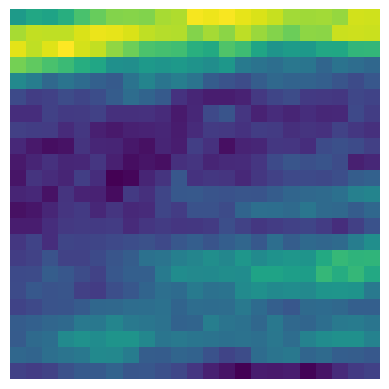

(21, 21)


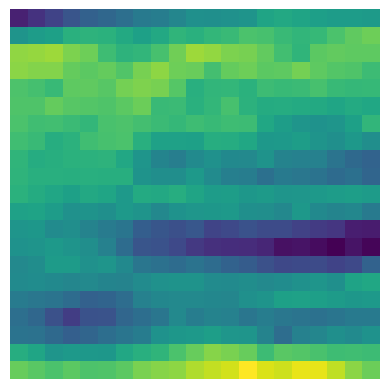

(19, 19)


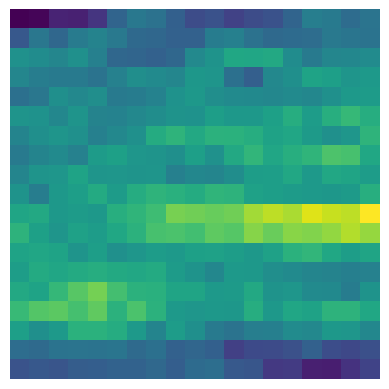

(19, 19)


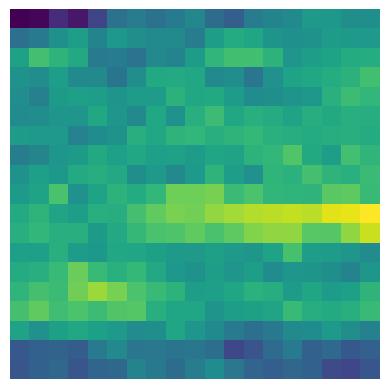

(17, 17)


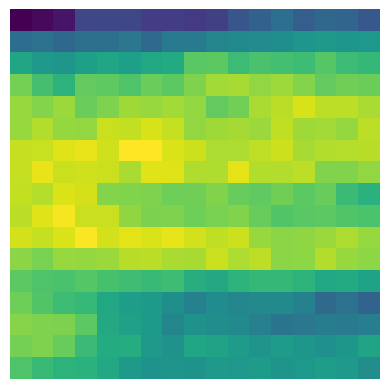

(15, 15)


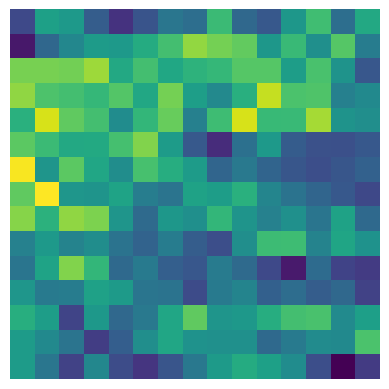

(13, 13)


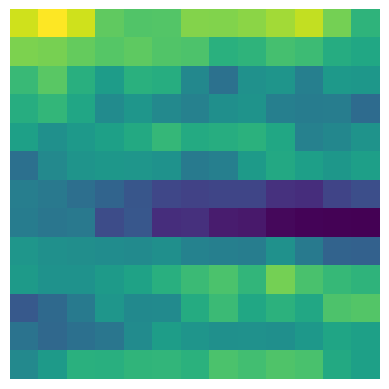

(11, 11)


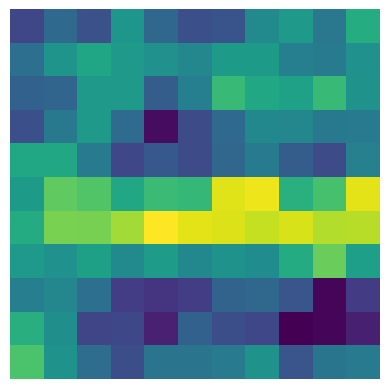

(9, 9)


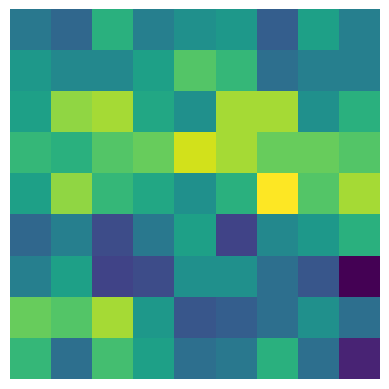

(7, 7)


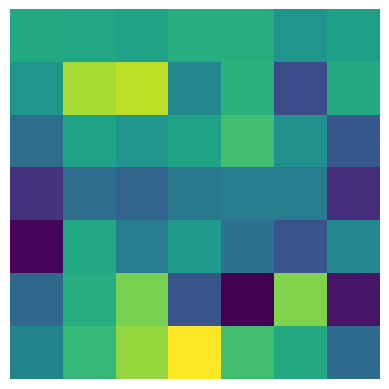

(5, 5)


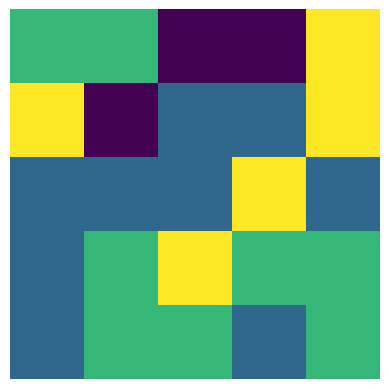

In [66]:
for i, tensor in enumerate(tensors):
    sliced_tensor = tensor[0, 69, :, :].detach().numpy()

    # Plot the sliced tensor
    print(sliced_tensor.shape)
    plt.imshow(sliced_tensor)
    plt.axis('off')  # Turn off the axis
    plt.show()

In [67]:
for batch in range(70):
    for i, tensor in enumerate(tensors):
        sliced_tensor = tensor[0, batch, :, :].detach().numpy()

        # Plot the sliced tensor
        plt.imshow(sliced_tensor)
        plt.axis('off')  # Turn off the axis

        # Save the figure
        filename = f'./hidden_img/hidden_output2_{tensors_name[i]}.png'
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)
        plt.close()  # Close the plot to avoid displaying it again

In [59]:
for i, tensor in enumerate(tensors):
    sliced_tensor = tensor[0, i, :, :].detach().numpy()

    # Plot the sliced tensor
    plt.imshow(sliced_tensor)
    plt.axis('off')  # Turn off the axis

    # Save the figure
    filename = f'./hidden_img/hidden_output_{tensors_name[i]}.png'
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close()  # Close the plot to avoid displaying it again

In [42]:
from PIL import Image
import os

# Tensor names, assuming they are the same as in the original code snippet
tensors_name = ['x_0d_1', 'x_0d_2', 'x_0d_3', 'x', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8']

# Read images from the specified file paths
images = []
for name in tensors_name:
    filepath = f'./hidden_img/hidden_output_{name}.png'
    if os.path.exists(filepath):
        images.append(Image.open(filepath))

# Check if there are any images loaded
if not images:
    print("No images found in the specified directory.")
else:
    # Determine the grid size for the tile plot
    num_images = len(images)
    grid_size = int(np.ceil(np.sqrt(num_images)))

    # Create a blank canvas to place the images
    img_width, img_height = images[0].size
    canvas = Image.new('RGB', (grid_size * img_width, grid_size * img_height))

    # Place each image onto the canvas
    for i, img in enumerate(images):
        row = i // grid_size
        col = i % grid_size
        canvas.paste(img, (col * img_width, row * img_height))

    # Display the canvas
    plt.imshow(canvas)
    plt.axis('off')

    # Save the figure
    tile_image_path = './hidden_img/tiled_hidden_outputs.png'
    canvas.save(tile_image_path)
    plt.close()  # Close the plot to avoid displaying it again

    tile_image_path


In [60]:
for batch in range(70):
    for i, tensor in enumerate(tensors):
        sliced_tensor = tensor[0, batch, :, :].detach().numpy()

        # Plot the sliced tensor
        plt.imshow(sliced_tensor)
        plt.axis('off')  # Turn off the axis

        # Save the figure
        filename = f'./hidden_img/hidden_output_{tensors_name[i]}.png'
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)
        plt.close()  # Close the plot to avoid displaying it again


    images = []
    for name in tensors_name:
        filepath = f'./hidden_img/hidden_output_{name}.png'
        if os.path.exists(filepath):
            images.append(Image.open(filepath))

    # Check if there are any images loaded
    if not images:
        print("No images found in the specified directory.")
    else:
        # Determine the grid size for the tile plot
        num_images = len(images)
        grid_size = int(np.ceil(np.sqrt(num_images)))

        # Create a blank canvas to place the images
        img_width, img_height = images[0].size
        canvas = Image.new('RGB', (grid_size * img_width, grid_size * img_height))

        # Place each image onto the canvas
        for i, img in enumerate(images):
            row = i // grid_size
            col = i % grid_size
            canvas.paste(img, (col * img_width, row * img_height))

        # Display the canvas
        plt.imshow(canvas)
        plt.axis('off')

        # Save the figure
        tile_image_path = f'./hidden_img/_batch{batch}.png'
        canvas.save(tile_image_path)
        plt.close()  # Close the plot to avoid displaying it again

        tile_image_path
    


In [44]:
for batch in range(70):

    image_paths = [f'./hidden_img/_batch{batch}.png' for batch in range(70)]
    frames = [Image.open(image_path) for image_path in image_paths if os.path.exists(image_path)]

    # アニメーションGIFを作成する（画像が存在する場合のみ）
    if frames:
        gif_path = './hidden_img/hidden_output_animation.gif'
        frames[0].save(gif_path, format='GIF', append_images=frames[1:], save_all=True, duration=100, loop=0)
    else:
        print("No images found to create an animation.")